# Imports

In [ ]:
# descargar librerias necesarias
!pip install pandas
!pip install xlrd
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import dayofweek, dayofyear, dayofmonth, weekofyear, month, year

from pyspark.sql import functions # usaremos -> mean, stddev, max, min, col

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# FUNCIONES FINALES PARA EL ANÁLISIS

Comentario: Se podrían explicar más en detalle las funciones en un script aparte y así el análisis / resultados queda más limpio.

In [3]:

def preprocess_dates(df):
        
    df_new = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("dayofyear", dayofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')
    return df_new


def preprocess_ids(df):
    
    data_geo  = "datos/bases_bicimad.csv"
    
    # cambiar los ids de las estaciones por el barrio respectivo
    df_geo  = spark.read.csv(data_geo, header=True)\
                            .select("Número", "Barrio")\
                                .withColumnRenamed("Número", "idplug_station")\
                                .withColumnRenamed("Barrio", "id_llegadas")
    df_geo2 = df_geo.withColumnRenamed("idplug_station", "idunplug_station")\
                                .withColumnRenamed("id_llegadas", "id_salidas")

    df_new = df.join(df_geo, on="idplug_station").join(df_geo2, on="idunplug_station")\
                            .drop("idplug_station", "idunplug_station", "idplug_base", "idunplug_base")
    
    # añadir la geolocalización de los barrios
    df_geo = spark.read.csv(data_geo, header=True)\
                            .select("Barrio", "Latitud", "Longitud")\
                                .withColumnRenamed("Barrio", "id_salidas")\
                                .withColumnRenamed("Latitud", "Latitud_salidas")\
                                .withColumnRenamed("Longitud", "Longitud_salidas")
    
    df_geo2 = df_geo.withColumnRenamed("id_salidas", "id_llegadas")\
                                .withColumnRenamed("Latitud_salidas", "Latitud_llegadas")\
                                .withColumnRenamed("Longitud_salidas", "Longitud_llegadas")
    
    df_new = df_new.join(df_geo, on="id_salidas").join(df_geo2, on="id_llegadas")
    
    return df_new



def get_random_barrio(df):
    # Serán pocos valores (el nº de barrios) por lo que aunque parezca que hay mucho paso 
    # a pandas y a listas, la operación no es costosa. De todas formas lo suyo es que seleccionemos nosotros
    # uno manualmente
    return np.random.choice(df.select("id_salidas").distinct().toPandas()["id_salidas"].to_list())

def get_years(df):
    # Guardar una lista con todos los años disponibles del DataFrame -> no serán más de 2 / 3 valores 
    # por lo que aunque parezca que hay mucho paso a pandas y a listas, la operación no es costosa
    years = df.select("year").distinct().toPandas()["year"].to_list()
    years = list(map(str, years)) # pasarlo a tipo string
    return years



def plot_analisys_by_day(df, barrio=None, total=False, years=None): # total == True -> estudio uniendo todos los barrios
    
     # Según queramos o no un estudio total modificamos el DataFrame
    if not total:
        if barrio == None:
            barrio = get_random_barrio(df)

        df_barrio = df.filter(df.id_salidas == barrio)
    else:
        df_barrio = df
    
    years = years if years != None else get_years(df)
    
    df_plot = None
    
    # Agrupamos por años los datos 
    for year in years:
        df_year = df_barrio.filter(df.year == year)\
                            .groupBy("dayofweek").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="dayofweek")
    
    # Ordenar temporalmente (dayofweek) y luego hacemos un plot de todos los años
    ss = f" del barrio:\n{barrio}" if not total else ""
    df_plot.orderBy("dayofweek").toPandas().plot.bar(
            x = "dayofweek", 
            y = years,
            title = f"Visualización de los movimientos\n por días de la semana{ss}",
            ylabel="nº de movimientos totales",
            xlabel=""
    ).set_xticklabels(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
    


def plot_analisys_by_year(df):
    
    years = get_years(df)
    
    df_plot = None
    
    # hacer una columna para cada año del conteo de la columna que queramos medir
    for year in years:
        df_year = df.filter(df.year == year)\
                            .groupBy("weekofyear").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="weekofyear")
    
    # ordenar temporalmente (weekofyear) y luego hacer un plot de todos los años
    df_plot.orderBy("weekofyear").toPandas().plot(
            x = "weekofyear", 
            y = years,
            title = "Visualización global\nde los movimientos de las bicis",
            xlabel="semana",
            ylabel="nº de movimientos"
    )


def plot_stats(df):
    
    years = get_years(df)
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    # nº de filas = len(years)
    f = len(years)
    
    # nº de columnas = 2 -> una para las gráficas y otro con geolocalizaciones y algún atributo
    c = 2
    
    # crear plot
    fig = plt.figure(figsize=(15,5*f))
    
    for i, year in enumerate(years):
        
        df2 = df.filter(df.year == year).groupBy('id_salidas', 'dayofweek').count().orderBy('id_salidas')

        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats = df2.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats["std"] = df_stats["std"] / df_stats["mean"] * df_stats["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats["dif"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]
        
        maximo_std = df_stats[df_stats["std"] == df_stats["std"].max()]
        maximo_dif = df_stats[df_stats["dif"] == df_stats["dif"].max()]

        # PLOT IZQUIERDO
        # --------------
        # Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        
        ax = fig.add_subplot(f, c, 2*i + 1)

        n = df_stats.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats["std"].values, "m-", label="std")
        ax.bar(x, df_stats["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std.index[0], maximo_std["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std["id_salidas"].values[0]))
        ax.bar(maximo_dif.index[0], maximo_dif["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--{year}--")

        
        # PLOT DERECHO
        # ------------
        # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
        #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
        #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

        ax = fig.add_subplot(f, c, 2*i + 2)
        
        # LOS PUTOS TIPOS ME HAN MATADO! al parecer al leer el csv no se guardaba en formato numérico y 
        # no los entendía aunque aparentemente estaban bien... Hay que preprocesarlos a un tipo float.
        # RECORDAR QUITAR ESTE COMENTARIO ;)
        df_stats.Latitud_salidas = df_stats.Latitud_salidas.astype("float64")
        df_stats.Longitud_salidas = df_stats.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats["Latitud_salidas"],
            y = df_stats["Longitud_salidas"],
            c = df_stats["mean"],
            s = df_stats["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--{year}--")

        
    
    plt.show()





def plot_stats_by_weekends(df):
    
    years = get_years(df)
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    
    for year in years:
        
        # crear plot
        fig = plt.figure(figsize=(15,5*2))
        f, c = 2, 2
    
        
        df2 = df.filter(df.year == year)\
                    .groupBy("id_salidas", "dayofweek").count()\
                    .orderBy("id_salidas")
        
        # si es fin de semana o no
        df_si = df2.filter(df2.dayofweek >= 4)
        df_no = df2.filter(df2.dayofweek <  4)


        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats_si = df_si.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        
        df_stats_no = df_no.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats_si["std"] = df_stats_si["std"] / df_stats_si["mean"] * df_stats_si["mean"].max()
        df_stats_no["std"] = df_stats_no["std"] / df_stats_no["mean"] * df_stats_no["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats_si["dif"] = (df_stats_si["max"] - df_stats_si["min"]) / df_stats_si["mean"]
        df_stats_no["dif"] = (df_stats_no["max"] - df_stats_no["min"]) / df_stats_no["mean"]
        
        # maximos
        maximo_std_si = df_stats_si[df_stats_si["std"] == df_stats_si["std"].max()]
        maximo_dif_si = df_stats_si[df_stats_si["dif"] == df_stats_si["dif"].max()]
        
        maximo_std_no = df_stats_no[df_stats_no["std"] == df_stats_no["std"].max()]
        maximo_dif_no = df_stats_no[df_stats_no["dif"] == df_stats_no["dif"].max()]

        # PLOT IZQUIERDO
        # --------------
        # Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        
        # --------------- ENTRE SEMANA ---------------
        
        ax = fig.add_subplot(f, c, 1)

        n = df_stats_no.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats_no["std"].values, "m-", label="std")
        ax.bar(x, df_stats_no["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std_no.index[0], maximo_std_no["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std_no["id_salidas"].values[0]))
        ax.bar(maximo_dif_no.index[0], maximo_dif_no["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif_no["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--Entre semana : {year}--")
        
        # --------------- FIN DE SEMANA ---------------
        
        ax = fig.add_subplot(f, c, 3)

        n = df_stats_si.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats_si["std"].values, "m-", label="std")
        ax.bar(x, df_stats_si["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std_si.index[0], maximo_std_si["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std_si["id_salidas"].values[0]))
        ax.bar(maximo_dif_si.index[0], maximo_dif_si["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif_si["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--Fines de semana : {year}--")

        
        # PLOT DERECHO
        # ------------
        # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
        #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
        #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

        # --------------- ENTRE SEMANA ---------------

        ax = fig.add_subplot(f, c, 2)
        
        df_stats_no.Latitud_salidas = df_stats_no.Latitud_salidas.astype("float64")
        df_stats_no.Longitud_salidas = df_stats_no.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats_no["Latitud_salidas"],
            y = df_stats_no["Longitud_salidas"],
            c = df_stats_no["mean"],
            s = df_stats_no["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--Entre semana : {year}--")

        # --------------- FIN DE SEMANA ---------------

        ax = fig.add_subplot(f, c, 4)
        
        df_stats_si.Latitud_salidas = df_stats_si.Latitud_salidas.astype("float64")
        df_stats_si.Longitud_salidas = df_stats_si.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats_si["Latitud_salidas"],
            y = df_stats_si["Longitud_salidas"],
            c = df_stats_si["mean"],
            s = df_stats_si["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--Fines de semana : {year}--")
    
        plt.show()


def plot_diferencias_entrada_salida_por_barrios(df):
        
    years = get_years(df)
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])\
                                .withColumnRenamed("id_salidas", "id")\
                                .withColumnRenamed("Latitud_salidas", "Latitud")\
                                .withColumnRenamed("Longitud_salidas", "Longitud")\
    
    for year in years:
        
        # sacar los datos de llegadas y salidas
        df_salidas = df.filter(df.year == year).groupBy('id_salidas').count()\
                                        .withColumnRenamed("id_salidas", "id")\
                                        .withColumnRenamed("count", "n_salidas")\
                                        .join(df_geo, "id_salidas", "left")\
                                        .orderBy("id")
        df_llegadas = df.filter(df.year == year).groupBy('id_llegadas').count()\
                                        .withColumnRenamed("id_llegadas", "id")\
                                        .withColumnRenamed("count", "n_llegadas")\
                                        .join(df_geo, "id_llegadas", "left")\
                                        .orderBy("id")
        
        df_total = df_salidas.join(df_llegadas, on="id").join(df_geo, on="id")
        df_total = df_total.withColumn("diferencia", functions.col("n_salidas") - functions.col("n_salidas"))\
                                                                                                    .toPandas()
        
        

        # PLOT IZQUIERDO
        # --------------
                
        df_total.plot.bar(
                x = "id",
                y = ["n_salidas", "n_llegadas"],
                color = ["green", "red"],
                xlabel = "Barrios",
                title = f"Salidas vs Llegadas\n--{year}--"
        )

        
        # PLOT DERECHO
        # ------------

        ax = fig.add_subplot(f, c, 2)
                
        ax.scatter(
            x = df_total["Latitud"],
            y = df_total["Longitud"],
            c = df_total["diferencia"],
            s = df_total["diferencia"],
            alpha = 0.8
        )


        plt.show()


# ANÁLISIS FINAL

### Cargar los datos

In [4]:
spark = SparkSession.builder.getOrCreate()

23/05/26 19:34:30 WARN Utils: Your hostname, pclab032 resolves to a loopback address: 127.0.1.1; using 147.96.132.249 instead (on interface eno1)
23/05/26 19:34:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/26 19:34:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/26 19:34:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/26 19:34:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/05/26 19:34:36 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [5]:
df = spark.read.json("datos/sample_10e4.json")

### Preprocesamiento de datos

In [6]:
df = preprocess_dates(df)
df = preprocess_ids(df)

### Visualizar movimientos globales por años

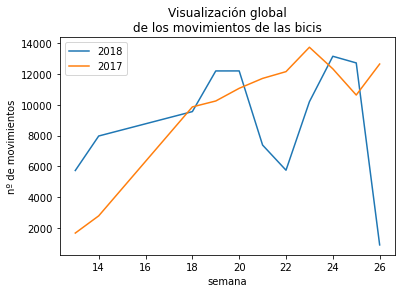

In [12]:
plot_analisys_by_year(df)

### Visualización de los movimientos semanales totales

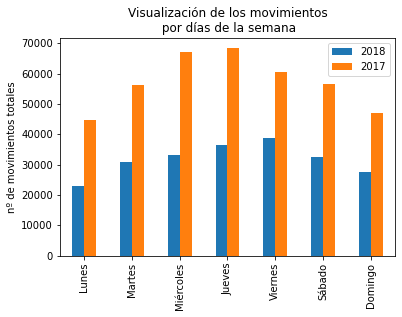

In [13]:
plot_analisys_by_day(df, total=True)

Parece que encontramos gran uniformidad en los datos, hay que tener en cuenta que este es un estudio global, por lo que nos está diciendo que durante todos los días de la semana se usan relativamente igual todas las bicis por Madrid.

Ahora bien, queremos observar por que zonas se mueven más unos días y por qué otras zonas se mueven otros días.

### Visualización de los movimientos semanales de un barrio concreto 

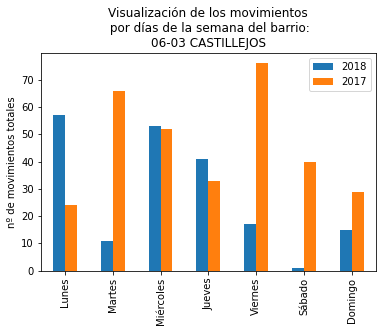

In [14]:
barrio = "06-03 CASTILLEJOS"
plot_analisys_by_day(df, barrio)

Se observa gran movimiento en general los viernes en 2017 y poco los domingos en ambos años. También observamos grandes diferencias entre ambos años el lunes.

Esta elección a sido aleatoria. Vamos ahora a buscar estadísticamente barrios interesantes de los que buscar resultados.

### Agrupar toda la información anterior por barrios, así podemos realizar unos análisis globales

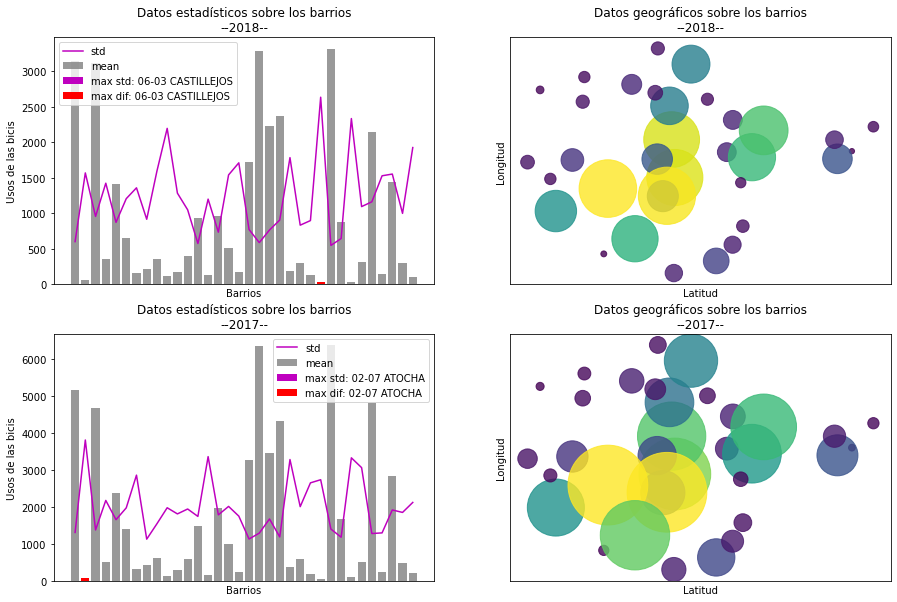

In [172]:
plot_stats(df)

De media, observamos mayores movimientos por el centro (los puntos amarillos) mientras que a las afueras menor uso de las bicicletas. Aquí podemos ver dónde se concentra el mayor movimiento en la ciudad.

Ahora bien, esto estaría increible si pudieramos hacer el mismo estudios (gráficos) donde nos muestre los movimientos en los fines de semana y en los días de trabajo laboral. Ahí sí se vería claramente  y gráficamnete donde hay mayores diferencias en el plot de la derecha. Mientras que el de la izquierda podríamos ver con detalle más estadístico diferencias concretas.

### Veamos los datos diarios de los barrios que nos han dado mayores desviaciones típicas y diferencias

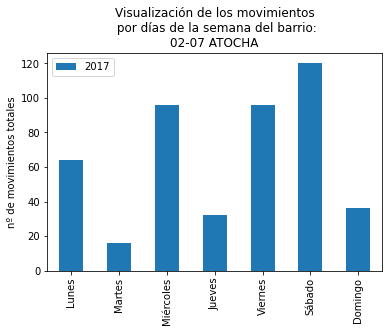

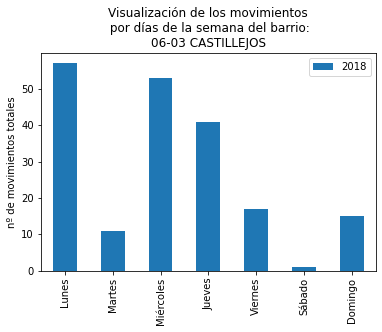

In [168]:
barrio_2017 = "02-07 ATOCHA"
barrio_2018 = "06-03 CASTILLEJOS"

plot_analisys_by_day(df, barrio_2017, years=["2017"])
plot_analisys_by_day(df, barrio_2018, years=["2018"])

 - Año 2017:
 
  - **02-07 ATOCHA**: se observa una diferencia considerable en los días viernes y sabado, es decir, durante la llegada del fin de semana es una zona bastante transitada a diferencia de los demás días de la semana.

 - Año 2018:
  
  - **06-03 CASTILLEJOS**: Se observa un claro descenso a lo largo del transcurso de la semana. Dejando los fines de semana casi inactivos en comparación con los días laborales.


### Ahora pordemos separar esto en vez de con todos los días de la semana separando en dos grupos:

 - Entre semana: Lunes, ..., Viernes
 - Fin de semana: Viernes, Sábado, Domingo

### y así conseguir un estudio final que nos diga en que zonas hay mucho cambio en la demanda entre laborales y fines de semana. 

**Tipos de joins:**: 'inner', 'outer', 'full', 'fullouter', 'full_outer', 'leftouter', 'left', 'left_outer', 'rightouter', 'right', 'right_outer', 'leftsemi', 'left_semi', 'semi', 'leftanti', 'left_anti', 'anti', 'cross'.

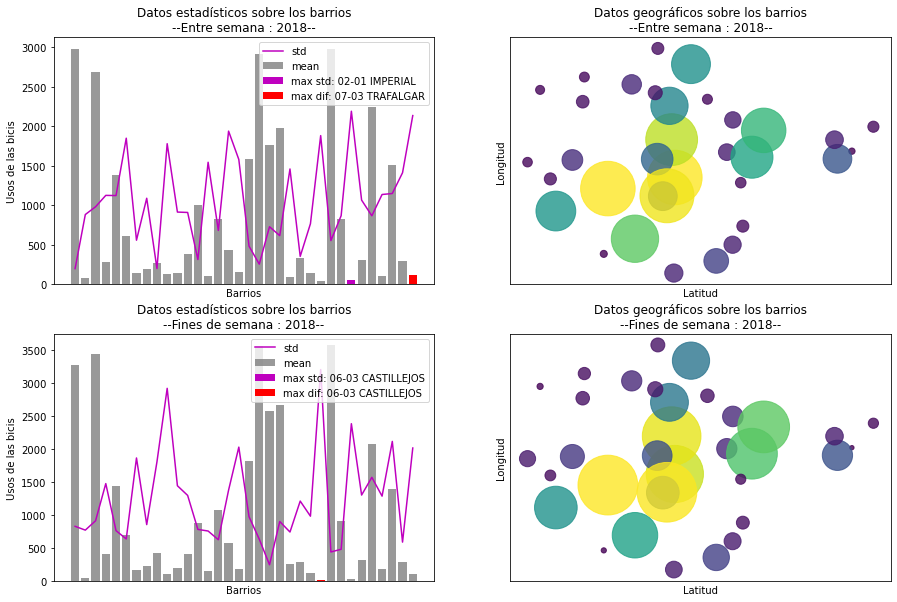

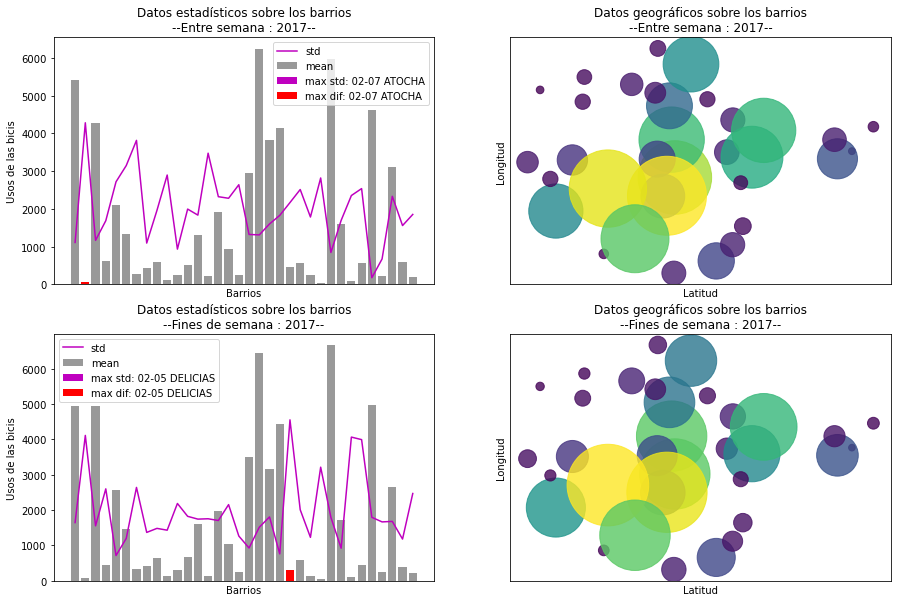

In [7]:
plot_stats_by_weekends(df)

Pues vaya, practicamente los fines de semana y entre semana parece que es muy parecido. Otra posibilidad es distinguir por estaciones (las 4) aunque ya no me da tiempo. En esas yo creo que sí habría gran diferencia entre verano e invierno por ejemplo. Pero eso sería más bien un análisis más que dar una solución a un problema.

### Ver diferencias entre entrada y salida de bicicletas por barrios

In [ ]:
plot_diferencias_entrada_salida_por_barrios(df)